In [87]:
import os
import pandas as pd
import numpy as np
import pickle
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

# Text Preprocessing
**Create the directories**

In [32]:
tesseract_files = os.listdir('../data/tesseract')
gtruth_files = os.listdir('../data/ground_truth')

**Build a word frequency count dictionary based on ground truth files**

In [33]:
truth_dic = {}

# read in all the ground truth files into a dictionary
for file_name in gtruth_files:
    path = '../data/ground_truth/'+file_name
    with open(path) as ground_file:
        ground_raw = ground_file.read()  # a string
        tokens = ground_raw.split()
        for tok in tokens:
            if tok in truth_dic:
                truth_dic.update({tok: truth_dic[tok]+1})
            else:
                truth_dic.update({tok: 1})

In [5]:
# truth_dic

**Build a token list for OCR output and a list for corresponding labels**

In [34]:
labels = []
ocr_output = []
for file_name in tesseract_files:
    path = '../data/tesseract/'+file_name
    with open(path) as ocr_file:
        ocr_raw = ocr_file.read()  # a string
        tokens = ocr_raw.split()
        for tok in tokens:
            ocr_output.append(tok)
            if tok in truth_dic:
                labels.append(0)
            else:
                labels.append(1)

In [7]:
print(ocr_output[:10])
print(labels[:10])

['communlcatlons', 'network.', 'Member', 'companles', 'are', 'strongly', 'encouraged', 'to', 'provlde', 'thls']
[1, 0, 0, 1, 0, 0, 0, 0, 1, 1]


In [8]:
print(len(ocr_output))
print(len(labels))

298728
298728


In [9]:
df = pd.DataFrame(data={"tokens": ocr_output, "labels": labels})
df.head()
# df.to_csv("./ocr_output.csv", sep=',',index=False)

,tokens,labels
0,communlcatlons,1
1,network.,0
2,Member,0
3,companles,1
4,are,0


**Feature generation in R** 

output a file "features.csv".

# SVM

Load features

In [35]:
features = pd.read_csv("../output/features.csv")
features.head()

,Unnamed: 0,tokens,labels,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,feature 10,feature 11,feature 12,feature 13
0,1,communlcatlons,1,14,0.285714,0.714286,0.396040,0.000,0.0,1.000000,0.000000,0.0,0,0,1,0.570100
1,2,network.,0,8,0.250000,0.625000,0.392157,0.125,0.0,0.875000,0.000000,0.0,0,0,1,0.261057
2,3,Member,0,6,0.333333,0.666667,0.487805,0.000,0.0,0.833333,0.166667,0.0,0,0,1,0.538740
3,4,companles,1,9,0.333333,0.666667,0.491803,0.000,0.0,1.000000,0.000000,0.0,0,0,1,0.672950
4,5,are,0,3,0.666667,0.333333,1.818182,0.000,0.0,1.000000,0.000000,0.0,0,0,1,1.137650


In [76]:
features[['labels']].isnull().sum()

labels    0
dtype: int64

In [50]:
features[['feature 13']] = features[['feature 13']].fillna(0)
features.shape

(298728, 16)

In [51]:
# normalize data
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()

X = features.iloc[:,3:]
X = scaler.fit_transform(X)
y = features[['labels']]
print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))

Feature space holds 298728 observations and 13 features
Unique target labels: [0 1]


In [80]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

print('training data has %d observation with %d features'% X_train.shape)
print('test data has %d observation with %d features'% X_test.shape)

training data has 238982 observation with 13 features
test data has 59746 observation with 13 features


In [81]:
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Train a subset

In [53]:
# indices = np.random.choice(len(X_train), size=100, replace=False)
# indices
# X_new = X_train[indices]
# y_new = y_train.loc[indices]

In [82]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [20]:
# from sklearn.svm import SVC

# parameters = {
# #     'C':(0.25, 0.75, 1, 1.25, 1.5, 2),
#     'C':(0.25, 0.75, 1),
#     'kernel': ('rbf','linear'),
# }
# Grid_SVM = GridSearchCV(SVC(), parameters, cv=5)
# Grid_SVM.fit(X_train, y_train)

In [ ]:
# print_grid_search_metrics(Grid_LR)

In [ ]:
# best_SVM_model = Grid_LR.best_estimator_

In [83]:
path = '../output/svm_model.pkl'
pickle.dump(svm_model, open(path, 'wb'))

In [84]:
saved_svm_model = pickle.load(open(path, 'rb'))
saved_svm_model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

# Model Evaluation

In [92]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

def draw_confusion_matrix(cm):
    class_names = ['Correct_Output','Incorrect_OCR_Output']
    
    classifier, cm = cm[0], cm[1]
    cal_evaluation(classifier, cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
    plt.title('Confusion matrix for %s' % classifier)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + class_names)
    ax.set_yticklabels([''] + class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

SVM
Accuracy is: 0.848
precision is: 0.859
recall is: 0.654


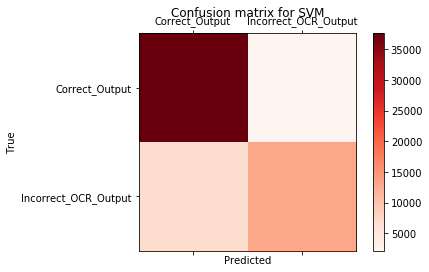

In [90]:
%matplotlib inline

cm = ["SVM", confusion_matrix(y_test,svm_model.predict(X_test))]

draw_confusion_matrix(cm)

In [95]:
y_test
features.head()

,Unnamed: 0,tokens,labels,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,feature 10,feature 11,feature 12,feature 13
0,1,communlcatlons,1,14,0.285714,0.714286,0.396040,0.000,0.0,1.000000,0.000000,0.0,0,0,1,0.570100
1,2,network.,0,8,0.250000,0.625000,0.392157,0.125,0.0,0.875000,0.000000,0.0,0,0,1,0.261057
2,3,Member,0,6,0.333333,0.666667,0.487805,0.000,0.0,0.833333,0.166667,0.0,0,0,1,0.538740
3,4,companles,1,9,0.333333,0.666667,0.491803,0.000,0.0,1.000000,0.000000,0.0,0,0,1,0.672950
4,5,are,0,3,0.666667,0.333333,1.818182,0.000,0.0,1.000000,0.000000,0.0,0,0,1,1.137650


In [100]:
# features[['tokens']].loc[y_test.index]

# Output the detected error for correction

In [103]:
y_pred = svm_model.predict(X)

In [108]:
# features[['tokens','labels']].loc[y_pred==1]
detected_error = features[['tokens']].loc[y_pred==1]
detected_error.head()

,tokens
0,communlcatlons
5,strongly
9,thls
16,1nclud1ng
25,1nvolved


In [109]:
detected_error.shape

(76036, 1)

In [110]:
detected_error.to_csv("../output/detected_errors.csv", sep=',',index=False)